# Exploring parameters

#### density plots, post predictive checks etc.

In [1]:
%load_ext autoreload
%autoreload 2
import os.path as op
import tempfile

import matplotlib.pyplot as plt


import hnn_core
from hnn_core import simulate_dipole, jones_2009_model
from hnn_core.viz import plot_dipole


import sys
sys.path.append('../code/')
sys.path.append('../code/utils/')
#sys.path.append('../code/sbi/')
#sys.path.append('../../results_cluster/')


import numpy as np
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt


import os

work_dir = '/home/ubuntu/sbi_for_eeg_data/code/'

os.chdir(work_dir)

#from utils.plot import cov, compare_vars, plot_varchanges
#from utils.plot import compare_KLs, plot_KLs
#from sbi.inference import potentials
import utils.sbi_modulated_functions

# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

from sbi.analysis import conditional_pairplot, conditional_corrcoeff



# import the summary statistics that you want to investigate
from summary_features.calculate_summary_features import calculate_summary_statistics_alternative as alternative_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal as temporal_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_number as number_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal


In [2]:
print(torch.__version__)

1.11.0


In [3]:
## defining neuronal network model

num_params = 6

from utils.simulation_wrapper import set_network_default, SimulationWrapper
sim_wrapper = SimulationWrapper(num_params, noise=False)


In [4]:
from utils import inference

import pickle
from data_load_writer import *
from data_load_writer import load_from_file as lf

import os

work_dir = '/home/ubuntu/'

os.chdir(work_dir)



import os

print(os.getcwd())



file = 'toy_example_mdn_08_04_lesser_ratio'


os.chdir('results/{}'.format(file))


print(os.getcwd())
  



/home/ubuntu
/home/ubuntu/results/toy_example_mdn_08_04_lesser_ratio


In [5]:
def Gaussian(thetas, normal_noise=1):
    
    gauss_list = []
    
    for theta in thetas:
    
        mu, sigma = theta, normal_noise # mean and standard deviation

        s = np.random.normal(mu, sigma, 1)
    
        
        gauss_list.append(s[0])
        
    gauss_obs = torch.tensor(gauss_list)
    
    return gauss_obs
    



In [6]:
list_collection = torch.load('list_collection.pt')
list_collection_inc = torch.load('list_collection_inc.pt')

In [7]:
true_thetas = torch.tensor([[3.0, 6.0, 20.0, 10.0, 90.0, 55.0, 27.0, 27.0, 4.0, 70.0, 5.0, 66.0, 99.0, 40.0, 45.0]])
parameter_names = ['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10', 't11', 't12', 't13', 't14', 't15']

prior_max = [100.0] * 15
prior_min = [1.0] * 15

prior = utils.torchutils.BoxUniform(low=prior_min, high = prior_max)

samples_prior = prior.sample((10000,))

simulator_stats, prior = prepare_for_sbi(Gaussian, prior)

In [8]:
samples_prior_list = samples_prior.unsqueeze(0)

In [9]:
samples_prior_list[0].shape

torch.Size([10000, 15])

In [10]:
thetas = inference.run_only_sim(samples_prior_list, simulation_wrapper = simulator_stats, num_workers=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished


In [11]:
def KL_Gauss(X, Y):
    
    sample_x = X.sample((1000,))
    mu_x = torch.mean(sample_x, dim=0)
    var_x = torch.std(sample_x, dim=0)

    var_y = Y.stddev

    mu_y = Y.mean
    
    
    return torch.mean(np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2)), var_x, mu_x


def calc_KL_1d(X, Y):
    
    sample_x = X.sample((1000,))
    mu_x = torch.mean(sample_x, dim=0)
    var_x = torch.std(sample_x, dim=0)
    
    print(var_x)
    print(mu_x)


    var_y = Y.stddev

    mu_y = Y.mean
    
    print(mu_y)
    print(var_y)
    
    print(np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2))
    
    return np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2)


# calculate the jensen-shanon divergence
def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

In [12]:

analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_snpe_list = []

variance_list_snpe = []

mean_list_snpe = []


## for round
for posterior_snpe_list in list_collection:
    
    KL_snpe = []
    KL_snpe_1d = []
    
    
    ## for number of simulations
    for posterior_snpe in posterior_snpe_list:


        #KL = KLdivergence(posterior_snpe, sample_y)
        KL, var_x, mu_x = KL_Gauss(posterior_snpe, analytic)
        
        variance_list_snpe.append(var_x)
        
        mean_list_snpe.append(mu_x)


        KL_1d = calc_KL_1d(posterior_snpe, analytic)

        KL_snpe_1d.append(KL_1d)

        #KL_snpe_sum.append(sum_KL)

        KL_snpe.append(KL)
        
    overall_snpe_list.append(KL_snpe)


    
    

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.308
acceptance rate:  0.3190909090909091


/home/ubuntu/pyknos/pyknos/mdn/mdn.py:288: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755861072/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  chosen_precision_factors,


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.316
acceptance rate:  0.32
tensor([4.8205, 5.2869, 6.0377, 3.8543, 3.8117, 9.1734, 8.3241, 5.2758, 3.6579,
        8.8285, 2.0940, 4.2360, 2.0830, 8.1761, 4.3625])
tensor([11.2455, 24.8062, 29.4347,  8.6499, 71.9557, 52.3166, 36.5587, 43.6702,
         7.7458, 75.3663,  3.8051, 48.4256, 96.7000, 27.0550, 36.4658])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 43.5397, 188.6471,  60.4359,   6.4900, 168.2252,  42.9595,  77.7110,
         150.7010,  11.9087,  50.6921,   1.6672, 161.4571,   3.5806, 114.6091,
          43.9588]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.271
acceptance rate:  0.2656363636363636


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.264
acceptance rate:  0.2639090909090909
tensor([ 5.1572,  4.8252,  6.7826, 11.5998,  5.9787,  6.3618,  4.2772,  5.6120,
         4.7107,  7.4185,  6.1286,  6.1161,  3.8561,  4.8238,  6.2943])
tensor([12.2597, 11.3249, 46.1946, 31.3322, 91.3992, 58.4261, 10.7226, 36.2399,
        15.3752, 61.2737, 19.5945, 78.1808, 95.3850, 41.9029, 47.9406])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 54.0287,  23.7448, 363.6649, 291.8587,  16.5633,  23.7550, 139.6698,
          56.2101,  73.7437,  63.0872, 122.9661,  90.5781,  12.1194,  11.3716,
          21.7928]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.944
acceptance rate:  0.9355454545454546


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.942
acceptance rate:  0.9335454545454546
tensor([9.2097, 5.9240, 4.3557, 4.9754, 7.9026, 3.4173, 8.6356, 4.4810, 9.4569,
        6.1807, 3.8281, 2.9352, 3.0758, 6.3514, 8.2523])
tensor([30.6640, 28.9353, 36.5226, 24.7207, 60.0866, 59.3330, 50.7751, 33.2127,
        43.5343, 54.4284, 21.1595, 50.7099, 91.0491, 22.2014, 80.6930])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[422.3382, 278.2812, 144.0120, 118.6220, 476.0656,  13.4976, 317.2582,
          27.3385, 823.4490, 138.0163, 136.0496, 119.6249,  34.7153, 176.2175,
         668.4356]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.261
acceptance rate:  0.26945454545454545


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.284
acceptance rate:  0.26554545454545453
tensor([1.7901, 1.6701, 4.4525, 1.2860, 3.1347, 2.3935, 1.5256, 2.4324, 2.1874,
        0.8898, 1.6458, 1.4900, 3.2673, 2.9029, 4.2617])
tensor([ 4.7354,  3.4699, 22.4552,  8.8875, 92.4131, 53.3647, 27.0982, 26.9872,
         4.7395, 68.5655,  3.5590, 64.8959, 94.8891, 40.4837, 41.9610])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 2.0258,  3.5824, 10.9328,  0.6942,  6.1822,  2.8286,  0.2462,  1.5695,
          1.3830,  1.0415,  1.3944,  0.8208, 12.1034,  2.7646, 11.7493]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.876
acceptance rate:  0.873


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.877
acceptance rate:  0.8656363636363636
tensor([5.2748, 7.7562, 7.6558, 6.1021, 5.3609, 1.6950, 1.6247, 3.3298, 4.0166,
        3.5085, 2.8184, 2.9461, 4.8385, 4.7863, 7.2802])
tensor([16.3122, 33.8315, 18.2653, 21.5887, 88.5270, 51.6613, 28.0558, 17.6425,
         8.9832, 65.4398, 15.8078, 71.8474, 89.9511, 38.6533, 35.9903])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[100.3563, 414.8258,  28.2748,  83.4578,  13.2751,   5.9822,   0.8918,
          47.6222,  18.5924,  14.7977,  60.8402,  19.8556,  50.5701,  10.2956,
          64.6034]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.292
acceptance rate:  0.28445454545454546


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.271
acceptance rate:  0.28063636363636363
tensor([2.5817, 4.4445, 7.7229, 2.1213, 3.1802, 1.7930, 2.2251, 3.6385, 1.4716,
        2.4266, 1.3581, 3.3379, 3.0835, 2.2463, 8.7818])
tensor([ 8.5915, 13.3011, 34.7644, 14.1445, 88.2970, 52.5540, 29.5988, 33.2764,
         2.9603, 64.7020,  6.9331, 58.9021, 94.0091, 35.4924, 28.9001])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 17.5168,  34.5384, 136.2713,   9.5862,   4.8500,   3.5149,   4.5525,
          24.5245,   0.7369,  15.5921,   1.9846,  29.0552,  15.5823,  11.3728,
         165.4898]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.547
acceptance rate:  0.5379090909090909


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.541
acceptance rate:  0.5435454545454546
tensor([4.6840, 5.6154, 5.9252, 4.9527, 7.3530, 5.8824, 4.1351, 4.2689, 5.3209,
        6.2782, 3.9192, 6.5155, 5.0533, 3.4205, 8.0036])
tensor([ 9.3133, 16.6275, 11.3198, 14.6006, 65.0211, 44.2893, 24.5825, 25.7187,
         8.9637, 85.9697,  8.1640, 81.3648, 82.3812, 36.7281, 34.2271])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 28.8549,  70.0132,  52.9479,  20.7475, 336.5110,  72.3886,   9.5521,
           7.9812,  24.3034, 144.8864,  10.8194, 136.8901, 148.7404,   9.4729,
          87.4759]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.792
acceptance rate:  0.7942727272727272


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.792
acceptance rate:  0.7962727272727272
tensor([4.3182, 5.4962, 4.4349, 5.2305, 5.2984, 7.2233, 5.3935, 5.9389, 4.3955,
        4.4203, 5.8453, 6.8011, 6.8531, 5.9965, 7.0673])
tensor([17.0147, 13.2373, 13.1290, 21.2472, 90.8863, 31.8316, 12.4344, 42.2003,
        16.2665, 67.3273, 12.4057, 44.1375, 76.3838, 35.5021, 18.8312])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[105.5667,  39.0894,  31.4498,  74.7745,  12.2620, 291.9988, 118.4374,
         130.8777,  82.9128,  11.3550,  42.2400, 259.6946, 276.8044,  25.8035,
         364.9223]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.728
acceptance rate:  0.7094545454545454


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.721
acceptance rate:  0.7020909090909091
tensor([7.6688, 8.4602, 3.5996, 3.7888, 5.5820, 5.3076, 2.3084, 5.9043, 8.9721,
        3.9466, 6.9332, 5.3970, 3.0390, 6.0937, 7.1146])
tensor([15.1153, 21.1072, 17.6973,  9.4769, 83.8415, 61.6022, 15.3567, 41.4650,
        26.9996, 66.7874, 24.6556, 89.7683, 94.6203, 47.5875, 66.2898])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[100.2588, 147.2659,   7.3488,   5.4823,  32.3237,  33.7106,  69.1115,
         119.7730, 302.0465,  11.0753, 214.7688, 294.8446,  12.5974,  45.0441,
         249.4747]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.345
acceptance rate:  0.3290909090909091


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.33
acceptance rate:  0.3418181818181818
tensor([5.1772, 3.2809, 4.2689, 4.1741, 2.9009, 3.1432, 4.8100, 2.0870, 4.0481,
        5.1237, 2.0804, 2.9198, 3.3857, 8.3120, 4.6005])
tensor([ 8.8296,  5.8270,  6.8886, 16.3938, 92.6953, 54.5422, 32.7536, 28.2087,
        10.5026, 53.6207,  8.1079, 57.6049, 90.4462, 23.3805, 42.6976])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 28.2494,   3.7091,  93.1145,  27.2232,   6.2747,   3.3993,  26.0490,
           1.6725,  27.4367, 145.1332,   5.7609,  37.9302,  40.5958, 170.0312,
          11.2066]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.02
acceptance rate:  0.027454545454545454
acceptance rate:  0.027
acceptance rate:  0.02570967741935484
acceptance rate:  0.026121951219512194


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.034
acceptance rate:  0.02890909090909091
acceptance rate:  0.02819047619047619
acceptance rate:  0.027064516129032257
acceptance rate:  0.027195121951219512
tensor([1.3355, 3.7114, 1.9754, 2.6728, 1.8223, 2.2803, 4.5175, 3.8806, 1.4315,
        2.0303, 1.7923, 0.8217, 1.8142, 2.0221, 6.9087])
tensor([ 3.0522,  7.8423, 19.5940,  7.8092, 90.4392, 53.2139, 21.5154, 23.8286,
         5.1726, 67.2758,  6.6636, 63.8747, 97.3633, 37.4992, 53.1804])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 0.1039,  6.7730,  0.8528,  4.4885,  0.6567,  2.8706, 23.2363, 10.7026,
          0.8533,  4.5634,  1.9064,  2.2924,  1.8894,  3.9673, 54.8911]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.474
acceptance rate:  0.4723636363636364


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.466
acceptance rate:  0.464
tensor([ 2.5165,  6.6870, 10.9470,  6.4247,  4.9578,  3.7683,  2.0581,  1.1414,
        11.8507,  1.9002,  2.2602,  3.3763,  1.2498,  2.2809,  3.1977])
tensor([11.6402, 19.0751, 19.1152, 19.6908, 81.9654, 52.9461, 27.8451, 25.5084,
        27.3624, 64.5281,  8.2252, 71.6972, 98.3243, 35.0471, 34.6376])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[3.9070e+01, 1.0544e+02, 5.7416e+01, 6.5234e+01, 4.2467e+01, 7.3827e+00,
         1.2531e+00, 1.1316e+00, 3.4015e+02, 1.5634e+01, 6.4398e+00, 2.0212e+01,
         2.8628e-01, 1.3542e+01, 5.7140e+01]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.072
acceptance rate:  0.06281818181818181
acceptance rate:  0.06119047619047619


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.062
acceptance rate:  0.05709090909090909
acceptance rate:  0.05914285714285714
tensor([3.9060, 7.7848, 5.8747, 3.6297, 4.4273, 6.3250, 4.7325, 4.3506, 4.1118,
        8.8926, 1.2955, 5.7030, 5.8884, 3.9422, 5.2341])
tensor([ 8.3121, 22.7970, 13.8421, 15.6330, 90.3085, 54.4660, 10.5875, 33.4953,
        11.0063, 70.5491,  2.5315, 60.0583, 81.1646, 50.2459, 46.9348])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 19.8750, 168.8191,  33.9454,  20.6639,   7.8603,  17.8010, 143.8285,
          28.5880,  31.0833,  37.0044,   3.1269,  31.6731, 174.1135,  58.3883,
          13.4145]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 902 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.008
acceptance rate:  0.00890909090909091
acceptance rate:  0.009857142857142858
acceptance rate:  0.01064516129032258
acceptance rate:  0.010439024390243903
acceptance rate:  0.010627450980392156
acceptance rate:  0.010590163934426229
acceptance rate:  0.010436619718309859
acceptance rate:  0.010444444444444444
acceptance rate:  0.010472527472527473
acceptance rate:  0.010475247524752476


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.013
acceptance rate:  0.011272727272727273
acceptance rate:  0.011476190476190477
acceptance rate:  0.01096774193548387
acceptance rate:  0.010609756097560976
acceptance rate:  0.010705882352941176
acceptance rate:  0.010721311475409835
acceptance rate:  0.010816901408450704
acceptance rate:  0.010753086419753087
acceptance rate:  0.010736263736263737
acceptance rate:  0.010623762376237625
tensor([1.1504, 2.9928, 4.8102, 1.8982, 1.2431, 2.2627, 1.5386, 3.7264, 1.6950,
        1.7802, 1.1891, 1.6788, 1.7447, 0.7007, 1.6953])
tensor([ 2.3424,  7.7204, 17.0882, 13.2774, 88.2925, 55.8825, 26.2552, 23.8352,
         8.3157, 65.9875,  2.3780, 64.1797, 97.6325, 40.9022, 48.3839])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 0.2378,  4.3622, 13.7374,  6.0313,  1.5127,  1.6327,  0.5301, 10.1356,
          9.7213,  8.5579,  3.4713,  2.0479,  1.400

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.546
acceptance rate:  0.5738181818181818


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.603
acceptance rate:  0.5871818181818181
tensor([0.9148, 2.1008, 5.0278, 3.8674, 2.3702, 4.5706, 5.0547, 4.2653, 3.8378,
        0.8683, 4.9094, 2.3714, 2.5436, 2.3183, 5.2253])
tensor([ 2.9093,  6.4480, 19.6968,  9.4054, 96.3708, 65.5844, 19.6371, 36.7626,
        14.6712, 71.6186, 17.8057, 58.3835, 95.6927, 39.1314, 36.7165])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1.1594e-02, 1.0647e+00, 1.0571e+01, 5.8024e+00, 2.1740e+01, 6.4441e+01,
         3.7761e+01, 5.4800e+01, 6.2457e+01, 1.3282e+00, 9.1953e+01, 3.0454e+01,
         7.2706e+00, 1.7237e+00, 4.5806e+01]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.001


                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 995 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.00045454545454545455
acceptance rate:  0.0003333333333333333
acceptance rate:  0.00045161290322580643
acceptance rate:  0.0003902439024390244
acceptance rate:  0.000392156862745098
acceptance rate:  0.0003278688524590164
acceptance rate:  0.0002957746478873239
acceptance rate:  0.0003333333333333333
acceptance rate:  0.00032967032967032967
acceptance rate:  0.0003465346534653465
acceptance rate:  0.0003243243243243243
acceptance rate:  0.0003140495867768595
acceptance rate:  0.0003053435114503817
acceptance rate:  0.00032624113475177306
acceptance rate:  0.00031125827814569535
acceptance rate:  0.00031055900621118014
acceptance rate:  0.00030994152046783625
acceptance rate:  0.0002983425414364641
acceptance rate:  0.0002879581151832461
acceptance rate:  0.0002935323383084577
acceptance rate:  0.00031753554502369667
acceptance rate:  0.00033936651583710406
acceptance rate:  0.00034199134199134197
acceptance rate:  0.00033195020746887966
acceptance rate:  0.0003386454

acceptance rate:  0.0003476352998537299
acceptance rate:  0.00034837457544881125
acceptance rate:  0.00034765813616610333
acceptance rate:  0.0003469485824123018
acceptance rate:  0.0003462458153993305
acceptance rate:  0.00034554973821989527
acceptance rate:  0.0003458076740881099
acceptance rate:  0.00034606317774634604
acceptance rate:  0.00034490849366494605
acceptance rate:  0.0003437645959831854
acceptance rate:  0.00034263133426313343
acceptance rate:  0.00034197130957889864
acceptance rate:  0.000342699216950714
acceptance rate:  0.00034296194406235674
acceptance rate:  0.0003427658603377453
acceptance rate:  0.00034257155838255337
acceptance rate:  0.0003419267299864315
acceptance rate:  0.0003408374606033318
acceptance rate:  0.0003402061855670103
acceptance rate:  0.0003395805443998215
acceptance rate:  0.00033896046201688137
acceptance rate:  0.00033878814683768244
acceptance rate:  0.0003386173491853809
acceptance rate:  0.0003388864533099518
acceptance rate:  0.0003387167

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 999 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.0
acceptance rate:  9.09090909090909e-05
acceptance rate:  9.523809523809524e-05
acceptance rate:  0.00022580645161290321
acceptance rate:  0.00024390243902439024
acceptance rate:  0.00025490196078431374
acceptance rate:  0.00026229508196721314
acceptance rate:  0.00028169014084507044
acceptance rate:  0.0002839506172839506
acceptance rate:  0.0002637362637362637
acceptance rate:  0.00025742574257425744
acceptance rate:  0.0002972972972972973
acceptance rate:  0.0003140495867768595
acceptance rate:  0.00029770992366412214
acceptance rate:  0.0002765957446808511
acceptance rate:  0.00027152317880794704
acceptance rate:  0.00028571428571428574
acceptance rate:  0.00029824561403508774
acceptance rate:  0.00030939226519337016
acceptance rate:  0.00029842931937172775
acceptance rate:  0.0002935323383084577
acceptance rate:  0.0002890995260663507
acceptance rate:  0.0002941176470588235
acceptance rate:  0.00028571428571428574
acceptance rate:  0.00029045643153526973
accep

acceptance rate:  0.0003148956817079088
acceptance rate:  0.00031434089811685175
acceptance rate:  0.0003142719846227775
acceptance rate:  0.0003127690100430416
acceptance rate:  0.00031175630652070444
acceptance rate:  0.0003117006158218854
acceptance rate:  0.0003125884016973126
acceptance rate:  0.00031206006569685596
acceptance rate:  0.00031106959364782813
acceptance rate:  0.0003110181311018131
acceptance rate:  0.0003114298935677927
acceptance rate:  0.0003118378627360663
acceptance rate:  0.00031270059605685466
acceptance rate:  0.000312186216339571
acceptance rate:  0.0003112221717401181
acceptance rate:  0.0003116236996834012
acceptance rate:  0.00031067086897793787
acceptance rate:  0.0003097265800089646
acceptance rate:  0.0003105756358768407
acceptance rate:  0.0003096401599289205
acceptance rate:  0.00030959752321981426
acceptance rate:  0.0003095552619991193
acceptance rate:  0.00030995177553704516
acceptance rate:  0.00030903535573985157
acceptance rate:  0.000309430682

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.449
acceptance rate:  0.478


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.482
acceptance rate:  0.4692727272727273
tensor([0.7729, 1.3404, 2.4002, 0.3036, 3.4672, 4.2655, 0.7315, 1.1802, 0.2149,
        0.6795, 0.6601, 0.6541, 0.9841, 0.6926, 0.9432])
tensor([ 2.4072,  5.3416, 20.3527, 10.0283, 91.4073, 55.8184, 25.9580, 28.4154,
         5.7457, 68.7679,  5.7166, 64.1342, 98.6167, 38.5422, 45.7342])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[0.2320, 0.3221, 1.5671, 0.7384, 5.2575, 7.4817, 0.6231, 1.0324, 2.5843,
         0.8763, 0.3900, 1.8790, 0.0737, 1.1698, 0.2728]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.022
acceptance rate:  0.021
acceptance rate:  0.02019047619047619
acceptance rate:  0.020225806451612902
acceptance rate:  0.01973170731707317
acceptance rate:  0.019862745098039217


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.019
acceptance rate:  0.019545454545454546
acceptance rate:  0.020476190476190478
acceptance rate:  0.020806451612903225
acceptance rate:  0.02075609756097561
acceptance rate:  0.0203921568627451
tensor([ 0.9768,  1.7486,  3.8908,  2.1852,  0.7755,  2.6796,  0.9480,  2.9505,
         5.7214,  0.9691,  0.6182,  0.6018,  6.1858,  5.6873, 11.1393])
tensor([ 2.2808,  6.1391, 25.1816,  7.8274, 91.1411, 52.3920, 25.1370, 31.3714,
        13.5972, 69.4804,  4.4238, 64.6733, 91.3155, 48.9680, 60.9397])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[2.5913e-01, 4.7964e-01, 1.9135e+01, 3.4659e+00, 7.0595e-01, 5.5051e+00,
         1.7382e+00, 1.2325e+01, 6.0176e+01, 1.3594e-01, 3.3809e-01, 1.0689e+00,
         4.6336e+01, 5.4147e+01, 1.8617e+02]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.153
acceptance rate:  0.1421818181818182


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.144
acceptance rate:  0.13763636363636364
tensor([ 4.2646,  2.4176,  6.1457,  6.6697,  6.6636,  7.6745, 13.6844,  5.5476,
         2.4066,  5.7077,  4.4652,  4.4325, 10.3325,  8.7585,  5.6150])
tensor([ 9.4647,  3.9431, 31.7236, 20.0546, 82.4987, 70.3848, 42.8974, 10.7657,
         4.1608, 63.1155,  7.1547, 60.0287, 69.8334, 25.2263, 42.6586])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 28.0394,   3.6549,  85.2908,  70.3925,  47.9396, 145.2578, 216.8786,
         144.9517,   1.5306,  37.7453,  10.2942,  25.6627, 475.8906, 144.8169,
          16.2799]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.125
acceptance rate:  0.12472727272727273


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.124
acceptance rate:  0.117
tensor([2.1419, 3.4543, 1.8328, 2.5747, 2.9068, 4.0727, 1.0485, 2.1714, 2.0905,
        2.3255, 1.5754, 1.9409, 2.3567, 4.4232, 3.5278])
tensor([ 5.3108,  6.9146, 17.1830,  5.2880, 86.4633, 50.5417, 26.0677, 24.4480,
         4.3601, 72.2366,  3.5908, 63.6772, 96.8363, 47.3672, 40.3927])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 3.7020,  4.6447,  4.5415, 12.9703,  8.9116, 16.3274,  0.4369,  4.3385,
          1.0125,  3.8613,  1.2794,  3.4182,  3.7606, 34.9337, 15.0756]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.41
acceptance rate:  0.41963636363636364


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.4
acceptance rate:  0.4133636363636364
tensor([1.8033, 2.4282, 3.2997, 3.1929, 2.5251, 4.2458, 2.5957, 3.8916, 6.6249,
        3.6598, 3.3734, 5.6797, 1.9905, 5.4109, 3.5495])
tensor([ 4.9149,  4.5612, 24.1097,  7.4291, 94.7081, 48.6128, 21.2205, 19.7891,
        16.4545, 76.0307,  8.0304, 68.5405, 97.3020, 48.8705, 50.6501])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 2.3698,  2.5959, 12.1952,  6.7410, 12.8449, 27.4658, 18.6164, 31.7120,
         97.1112, 23.0840,  8.5657, 17.1196,  2.2342, 51.7936, 20.4947]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.014
acceptance rate:  0.012181818181818183
acceptance rate:  0.011285714285714286
acceptance rate:  0.011612903225806452
acceptance rate:  0.011414634146341463
acceptance rate:  0.011156862745098039
acceptance rate:  0.010934426229508196
acceptance rate:  0.010788732394366196
acceptance rate:  0.01062962962962963
acceptance rate:  0.010758241758241758
acceptance rate:  0.01088118811881188


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.005
acceptance rate:  0.011545454545454546
acceptance rate:  0.010809523809523809
acceptance rate:  0.010870967741935484
acceptance rate:  0.011073170731707316
acceptance rate:  0.010980392156862745
acceptance rate:  0.011081967213114755
acceptance rate:  0.011
acceptance rate:  0.011185185185185185
acceptance rate:  0.011120879120879121
tensor([1.1026, 3.1046, 2.1558, 1.2039, 0.5811, 1.6213, 1.1640, 1.6293, 1.2368,
        0.7620, 1.2340, 0.8182, 1.9976, 2.3678, 1.8530])
tensor([ 2.6539,  8.2470, 22.6381,  9.4120, 90.5273, 57.8861, 24.2253, 27.6312,
         6.8784, 68.8186,  3.3526, 65.1425, 97.0922, 41.1819, 47.2404])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[0.0701, 5.7109, 4.5356, 0.2120, 0.3507, 4.4958, 3.8750, 0.5383, 4.1948,
         0.7600, 1.4082, 0.4030, 2.6231, 2.1396, 3.1097]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.461
acceptance rate:  0.451


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.479
acceptance rate:  0.44972727272727275
tensor([3.6153, 1.3157, 5.1371, 3.5907, 2.2687, 2.1069, 2.8017, 2.9166, 3.9985,
        3.3555, 2.6395, 4.9026, 1.6796, 2.5299, 2.0406])
tensor([ 7.3272,  6.2502, 18.7021,  8.1285, 96.3498, 54.1309, 27.0560, 22.0146,
         8.2230, 69.7172,  5.8629, 60.8491, 97.1283, 38.0303, 47.6989])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[14.1123,  0.1225, 11.9007,  6.4194, 21.4140,  1.3519,  2.3961, 15.1098,
         15.0248,  3.9592,  2.3851, 23.1935,  2.1436,  3.7120,  4.5109]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.989
acceptance rate:  0.9854545454545455


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.991
acceptance rate:  0.983
tensor([0.2758, 0.2982, 3.0477, 0.5502, 0.5520, 0.5468, 0.2733, 0.8593, 0.3673,
        0.2439, 0.7130, 3.4067, 3.4189, 2.1985, 2.9133])
tensor([ 4.1841,  5.0404, 27.8598, 10.8463, 89.7861, 54.9524, 25.3767, 28.8777,
         6.3002, 69.4802,  6.2665, 56.4905, 91.6405, 45.0751, 38.5487])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 1.5273,  1.2147, 33.9183,  0.6070,  0.2694,  0.2543,  2.1522,  1.7838,
          3.2146,  1.0760,  0.8944, 49.2918, 31.1961, 14.0075, 23.4840]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.421
acceptance rate:  0.42872727272727273


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.446
acceptance rate:  0.4390909090909091
tensor([ 4.6583, 10.9772,  4.5373,  4.1132, 11.9003,  4.4968,  8.9596,  8.6210,
        12.8220,  7.5362,  8.9725, 10.3036,  7.2998,  7.0872,  7.6150])
tensor([ 8.2896, 41.8984, 25.5969,  6.5812, 51.4382, 73.4817, 23.0693, 44.8301,
        42.5504, 88.1000, 20.0260, 50.0025, 84.7280, 27.2227, 62.8715])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 22.8013, 701.6996,  23.9441,  12.3889, 811.3375, 178.8932,  45.1699,
         193.4625, 822.2161, 189.6815, 150.4480, 178.2098, 126.0003, 104.2851,
         186.1594]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.059
acceptance rate:  0.059
acceptance rate:  0.057761904761904764


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.041
acceptance rate:  0.054
acceptance rate:  0.05423809523809524
tensor([1.0967, 2.9192, 4.1679, 4.4331, 8.1433, 3.0868, 4.3216, 1.6814, 2.0822,
        5.0414, 2.2345, 4.4178, 1.3884, 5.9660, 3.5211])
tensor([ 2.3498,  5.1164, 27.0900,  9.8818, 72.9861, 62.2776, 14.8156, 29.8869,
         4.0300, 69.4995,  6.1525, 70.9394, 97.9694, 40.3897, 52.8159])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[  0.2205,   3.0799,  31.8925,   7.8439, 175.2947,  29.6188,  81.6042,
           4.5611,   0.9348,  10.7155,   1.8566,  19.9716,   0.6667,  15.5864,
          34.9846]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.473
acceptance rate:  0.46636363636363637


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.475
acceptance rate:  0.47263636363636363
tensor([2.0839, 1.8857, 2.4342, 2.6136, 1.8619, 2.4735, 1.7176, 2.7952, 4.4506,
        2.7027, 1.6571, 3.0120, 1.4430, 3.2918, 2.4542])
tensor([ 4.1806,  6.4036, 18.1192,  4.8060, 91.1845, 54.8441, 25.9249, 27.9980,
        11.9136, 72.2637,  4.6186, 59.6206, 97.6719, 35.0948, 49.6482])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 1.6339,  0.7250,  3.3418, 15.4433,  1.3133,  1.6656,  1.0120,  2.8766,
         39.2231,  4.7204,  0.4406, 23.2817,  1.0564, 15.7570, 12.4164]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.467
acceptance rate:  0.48572727272727273


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.501
acceptance rate:  0.47609090909090906
tensor([2.3427, 5.3109, 6.2661, 3.9009, 4.3667, 4.5089, 4.2983, 3.3952, 4.7092,
        5.6828, 3.8853, 1.7994, 4.0634, 6.4387, 1.8949])
tensor([ 8.6234, 16.6987, 13.4191,  6.6907, 78.5565, 64.3868, 11.2756, 28.4276,
         9.1293, 87.6211,  9.5349, 62.5678, 89.6251, 33.5131, 44.6503])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 17.2038,  69.1639,  38.9510,  11.2230,  73.0372,  52.2149, 130.9074,
           5.0604,  22.1937, 169.1616,  15.9731,   6.4216,  50.2979,  39.4058,
           0.7173]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.408
acceptance rate:  0.40745454545454546


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.396
acceptance rate:  0.39736363636363636
tensor([1.2632, 1.2159, 2.0331, 2.2046, 1.6937, 2.1192, 4.5108, 1.5325, 0.6610,
        0.7728, 0.8227, 1.7935, 1.8267, 2.0957, 7.1564])
tensor([ 5.1925,  2.7168, 21.1121,  8.3780, 93.3291, 55.6833, 21.6495, 28.0336,
         5.9148, 69.5802,  4.5813, 66.5983, 97.4204, 37.2328, 37.6090])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 2.4678,  5.4334,  1.4755,  2.4549,  5.9487,  1.2280, 22.4814,  0.7816,
          1.9656,  0.1445,  0.1212,  0.7032,  1.8135,  4.7847, 50.4523]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.056
acceptance rate:  0.062
acceptance rate:  0.06447619047619048


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.07
acceptance rate:  0.063
acceptance rate:  0.06290476190476191
tensor([ 2.3849,  1.5566,  9.0622,  1.7679,  1.2368,  0.4971,  1.0710,  0.6788,
         1.1523,  0.4205,  5.5423, 11.5323,  1.3313,  1.9982, 11.5522])
tensor([ 7.2816,  6.5000, 32.5972, 11.6879, 92.4275, 55.6739, 26.6115, 27.4883,
         3.9708, 69.8333, 12.4087, 80.7315, 97.6598, 42.3220, 29.5160])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1.0641e+01, 3.9402e-01, 1.1770e+02, 1.9174e+00, 2.9986e+00, 5.4959e-01,
         8.0397e-02, 2.3706e-01, 2.2562e-02, 4.6852e-01, 4.0590e+01, 1.7206e+02,
         9.9812e-01, 3.5000e+00, 1.8366e+02]])


In [13]:
torch.manual_seed(5)
np.random.seed(5)

obs_real = Gaussian(true_thetas[0, 0:])



analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_incremental_list = []

variance_list = []

mean_list = []

for posterior_incremental_list in list_collection_inc:
    
    KL_incremental = []

    for posterior_incremental in posterior_incremental_list:

        posterior_incremental.set_default_x(obs_real)

        #KL = KLdivergence(posterior_incremental, sample_y)

        KL, var_x, mu_x = KL_Gauss(posterior_incremental, analytic)
        
        variance_list.append(var_x)
        mean_list.append(mu_x)

        #KL_1d = calc_KL_1d(posterior_incremental, analytic)

        #KL_incremental_1d.append(KL_1d)


        KL_incremental.append(KL)

        
    overall_incremental_list.append(KL_incremental)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


In [14]:
print(os.getcwd())
file = 'toy_example_mdn_05_04_no_ratio'



os.chdir('/home/ubuntu/results/{}'.format(file))

/home/ubuntu/results/toy_example_mdn_08_04_lesser_ratio


In [15]:
list_collection_inc_ratio = torch.load('list_collection_inc.pt')

In [16]:
file = 'toy_example_maf_13_04_greater_ratio'


os.chdir('/home/ubuntu/results/{}'.format(file))

In [17]:
list_collection_inc_greater_ratio = torch.load('list_collection_inc.pt')

obs_real = torch.load('obs_real.pt')

In [18]:
analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_incremental_list_ratio = []

variance_list_ratio = []

mean_list_ratio = []

for posterior_incremental_list in list_collection_inc_ratio:
    
    KL_incremental = []

    for posterior_incremental in posterior_incremental_list:

        posterior_incremental.set_default_x(obs_real)

        #KL = KLdivergence(posterior_incremental, sample_y)

        KL, var_x, mu_x = KL_Gauss(posterior_incremental, analytic)
        
        variance_list_ratio.append(var_x)
        mean_list.append(mu_x)

        #KL_1d = calc_KL_1d(posterior_incremental, analytic)

        #KL_incremental_1d.append(KL_1d)


        KL_incremental.append(KL)

        
    overall_incremental_list_ratio.append(KL_incremental)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


In [19]:
analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_incremental_list_greater_ratio = []

variance_list_greater_ratio = []

mean_list_greater_ratio = []

for posterior_incremental_list in list_collection_inc_greater_ratio:
    
    KL_incremental = []

    for posterior_incremental in posterior_incremental_list:

        posterior_incremental.set_default_x(obs_real)

        #KL = KLdivergence(posterior_incremental, sample_y)

        KL, var_x, mu_x = KL_Gauss(posterior_incremental, analytic)
        
        variance_list_greater_ratio.append(var_x)
        mean_list_greater_ratio.append(mu_x)

        #KL_1d = calc_KL_1d(posterior_incremental, analytic)

        #KL_incremental_1d.append(KL_1d)


        KL_incremental.append(KL)

        
    overall_incremental_list_greater_ratio.append(KL_incremental)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


In [20]:
len(variance_list)

30

In [21]:
#mean_nipe = torch.mean(torch.stack(([variance_list[i] for i in range(25,30)]), dim=1), dim=1)

#std_nipe = torch.std(torch.stack(([variance_list[i] for i in range(25,30)]), dim=1), dim=1)


nipe_array = torch.stack(([variance_list[i] for i in range(25,30)]), dim=1)

snpe_array = torch.stack(([variance_list_snpe[i] for i in range(25,30)]), dim=1)

nipe_noratio_array = torch.stack(([variance_list_ratio[i] for i in range(25,30)]), dim=1)

nipe_greater_ratio_array = torch.stack(([variance_list_greater_ratio[i] for i in range(15, 20)]), dim=1)



In [22]:
len(variance_list_greater_ratio)

20

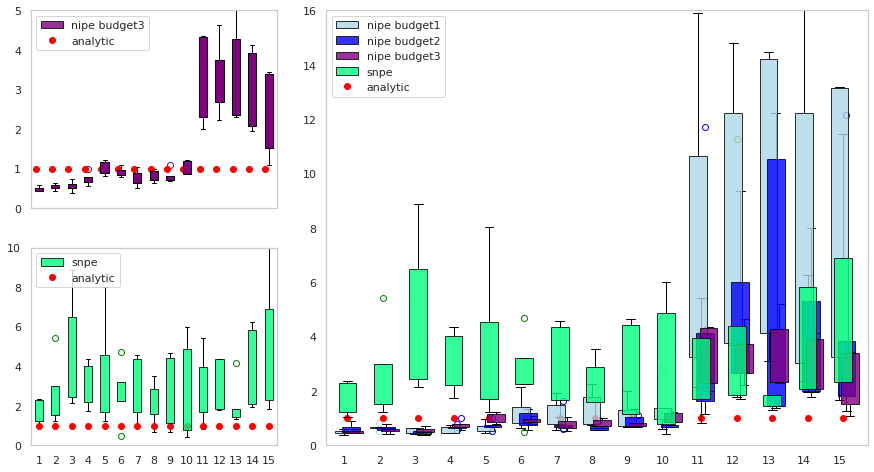

In [41]:
### plot variances:
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : False})
#sns.set_context('talk')
sns.set_context('notebook')

figure_mosaic = """
ACC
BCC
"""

fig, axes = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(15, 8))

#axes['A'].plot(variance_list[58],'o', label='nipe', c='blue')

#nipe_box  = axes['A'].boxplot(nipe_noratio_array, patch_artist=True, boxprops=dict(facecolor='lightblue'), medianprops=dict(color='red'),            
#            flierprops=dict(color='lightblue', markeredgecolor='blue'),positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 
#                                                                                 14, 15])
axes['A'].set(xticklabels=[])
#nipe_ratio_box  = axes['A'].boxplot(nipe_array, patch_artist=True, boxprops=dict(facecolor='blue'), medianprops=dict(color='red'),            
#            flierprops=dict(color='blue', markeredgecolor='blue'),positions=[1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1, 9.1, 10.1, 11.1, 12.1, 13.1, 
#                                                                                 14.1, 15.1])

nipe_greater = axes['A'].boxplot(nipe_greater_ratio_array, patch_artist=True, boxprops=dict(facecolor='purple'), medianprops=dict(linewidth=0),            
            flierprops=dict(color='purple', markeredgecolor='purple'),positions=[1.2, 2.2, 3.2, 4.2, 5.2, 6.2, 7.2, 8.2, 9.2, 10.2, 11.2, 12.2, 13.2, 
                                                                                 14.2, 15.2])
axes['A'].set(xticklabels=[])


axes['A'].set_ylim(0,5)

snpe_box = axes['B'].boxplot(snpe_array, patch_artist=True, boxprops=dict(facecolor='springgreen'), medianprops=dict(linewidth=0),flierprops=dict(color='green', markeredgecolor='green'),)
axes['B'].set_ylim(0,10)


#axes['A'].plot(variance_list[59],'o', label='nipe', c='blue')
#axes['A'].plot(variance_list[57],'o', label='nipe', c='blue')


nipe_box = axes['C'].boxplot(nipe_noratio_array, patch_artist=True, medianprops = dict(linewidth=0), boxprops=dict(facecolor='lightblue'),  flierprops=dict(color='lightblue', markeredgecolor='lightblue'),
                  positions=[0.9, 1.9, 2.9, 3.9, 4.9, 5.9, 6.9, 7.9, 8.9, 9.9, 10.9, 11.9, 12.9, 13.9, 
                                                                                 14.9])


nipe_ratio_box = axes['C'].boxplot(nipe_array, patch_artist=True, medianprops = dict(linewidth=0), boxprops=dict(facecolor='blue'),            
            flierprops=dict(color='blue', markeredgecolor='blue'),positions=[1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1, 9.1, 10.1, 11.1, 12.1, 13.1, 
                                                                                 14.1, 15.1])

nipe_greater = axes['C'].boxplot(nipe_greater_ratio_array, medianprops = dict(linewidth=0),patch_artist=True, boxprops=dict(facecolor='purple'),            
            flierprops=dict(color='blue', markeredgecolor='blue'),positions=[1.2, 2.2, 3.2, 4.2, 5.2, 6.2, 7.2, 8.2, 9.2, 10.2, 11.2, 12.2, 13.2, 
                                                                                 14.2, 15.2])

for b in nipe_greater['boxes']:
    b.set_alpha(0.8)
    
for b in nipe_ratio_box['boxes']:
    b.set_alpha(0.8)

for b in nipe_box['boxes']:
    b.set_alpha(0.8)
    
for b in snpe_box['boxes']:
    b.set_alpha(0.8)
    
    
axes['C'].set(xticklabels=[])

ana_plot = axes['A'].plot(np.linspace(1,15, 15), analytic.stddev[0], 'o', c='red', label='analytic')

    
axes['B'].plot(np.linspace(1,15, 15), analytic.stddev[0], 'o', c='red', label='analytic')
axes['C'].plot(np.linspace(1,15, 15), analytic.stddev[0], 'o', c='red', label='analytic')

#axes['B'].plot(variance_list_snpe[59],'o', c='g', label = 'snpe')
snpe_c = axes['C'].boxplot(snpe_array, patch_artist=True, medianprops = dict(linewidth=0),
                  boxprops=dict(facecolor='springgreen'), flierprops=dict(color='springgreen', markeredgecolor='green'),
                  )

for b in snpe_c['boxes']:
    b.set_alpha(0.8)
    
axes['C'].set_ylim(0,16)

axes['C'].legend()

axes['B'].legend([snpe_box['boxes'][0], ana_plot[0]], ['snpe', 'analytic'], loc='upper left')
axes['A'].legend([nipe_greater['boxes'][0], ana_plot[0]], ['nipe budget3',  'analytic'], loc='upper left')
axes['C'].legend([nipe_box['boxes'][0], nipe_ratio_box['boxes'][0],  nipe_greater['boxes'][0], snpe_box['boxes'][0], ana_plot[0]], ['nipe budget1', 'nipe budget2', 'nipe budget3','snpe', 'analytic'], loc='upper left')

In [17]:
nipe_array = torch.stack(([mean_list[i] for i in range(10)]), dim=1)


snpe_array = torch.stack(([mean_list_snpe[i] for i in range(10)]), dim=1)

In [18]:
analytic.mean

tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])

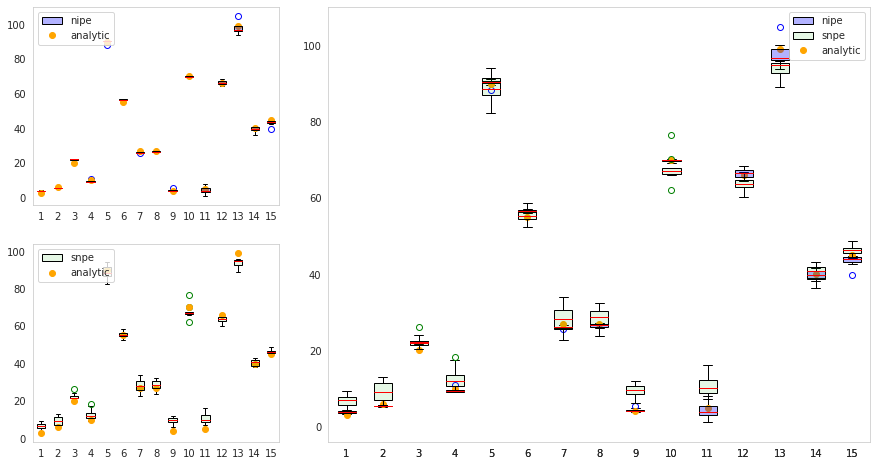

In [19]:
### plot means:
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : False})

figure_mosaic = """
ACC
BCC
"""

fig, axes = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(15, 8))

#axes['A'].plot(variance_list[58],'o', label='nipe', c='blue')

nipe_box  = axes['A'].boxplot(nipe_array, patch_artist=True, boxprops=dict(facecolor='blue'), medianprops=dict(color='red'),            
            flierprops=dict(color='blue', markeredgecolor='blue'))

[patch.set(alpha=None, facecolor=(0.,0.,1,.3)) for patch in nipe_box['boxes']]

#axes['A'].set_ylim(0,15)

snpe_box = axes['B'].boxplot(snpe_array, patch_artist=True, boxprops=dict(facecolor='green'), medianprops=dict(color='red'),flierprops=dict(color='green', markeredgecolor='green'),)
#axes['B'].set_ylim(0,15)

[patch.set(alpha=None, facecolor=(0,0.7,0,.1)) for patch in snpe_box['boxes']]


#axes['A'].plot(variance_list[59],'o', label='nipe', c='blue')
#axes['A'].plot(variance_list[57],'o', label='nipe', c='blue')


nipe_box2 = axes['C'].boxplot(nipe_array, patch_artist=True, boxprops=dict(facecolor='blue'), medianprops=dict(color='red'), flierprops=dict(color='blue', markeredgecolor='blue'),)

ana_plot = axes['A'].plot(np.linspace(1,15, 15), analytic.mean[0], 'o', c='orange', label='analytic')
axes['B'].plot(np.linspace(1,15, 15), analytic.mean[0], 'o', c='orange', label='analytic')
axes['C'].plot(np.linspace(1,15, 15), analytic.mean[0], 'o', c='orange', label='analytic')

#axes['B'].plot(variance_list_snpe[59],'o', c='g', label = 'snpe')
snpe_box2 = axes['C'].boxplot(snpe_array, patch_artist=True, boxprops=dict(facecolor='green'), medianprops=dict(color='red'), flierprops=dict(color='green', markeredgecolor='green'),)
#axes['C'].set_ylim(0,15)

[patch.set(alpha=None, facecolor=(0,0.7,0,.1)) for patch in snpe_box2['boxes']]
[patch.set(alpha=None, facecolor=(0.,0.,1,.3)) for patch in nipe_box2['boxes']]

axes['C'].legend()

axes['B'].legend([snpe_box['boxes'][0], ana_plot[0]], ['snpe', 'analytic'], loc='upper left')
axes['A'].legend([nipe_box['boxes'][0], ana_plot[0]], ['nipe',  'analytic'], loc='upper left')
axes['C'].legend([nipe_box['boxes'][0], snpe_box['boxes'][0], ana_plot[0]], ['nipe', 'snpe', 'analytic'], loc='upper right')